        Date  AverageTemperature
0 2001-01-01           -4.480333
1 2001-02-01           -7.541000
2 2001-03-01            0.590333
3 2001-04-01            7.889000
4 2001-05-01           13.908667


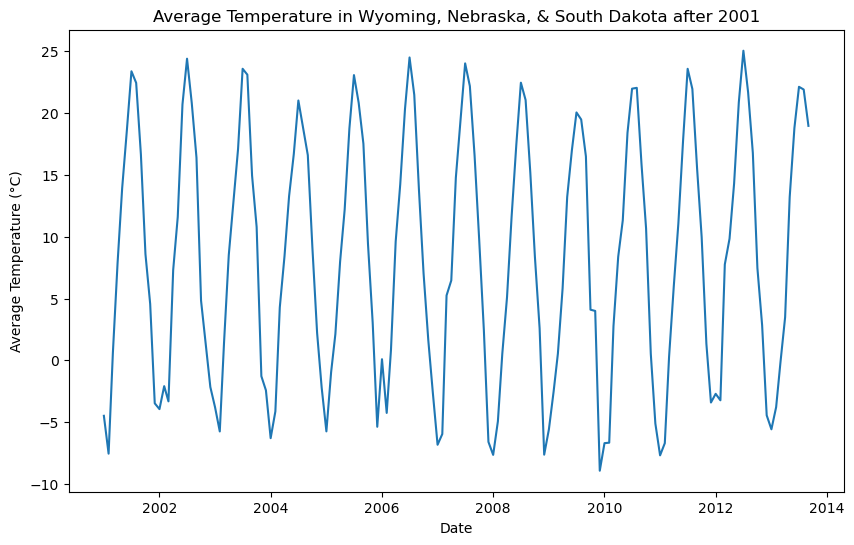

        Date  AverageTemperature  DateFloat
0 2001-01-01           -4.480333   1.002053
1 2001-02-01           -7.541000   1.086927
2 2001-03-01            0.590333   1.163587
3 2001-04-01            7.889000   1.248460
4 2001-05-01           13.908667   1.330595
Parameters with Errors: 
A : -13.898335734997955 ± 0.22650022678733475
w : 6.282884916376963 ± 0.004488544472332918
P : -0.05909572288033607 ± 0.0367795362844077
D : 8.174924038627141 ± 0.16069847289516928
y = -13.9 *cos( 6.28 *t + -0.06 ) + 8.17


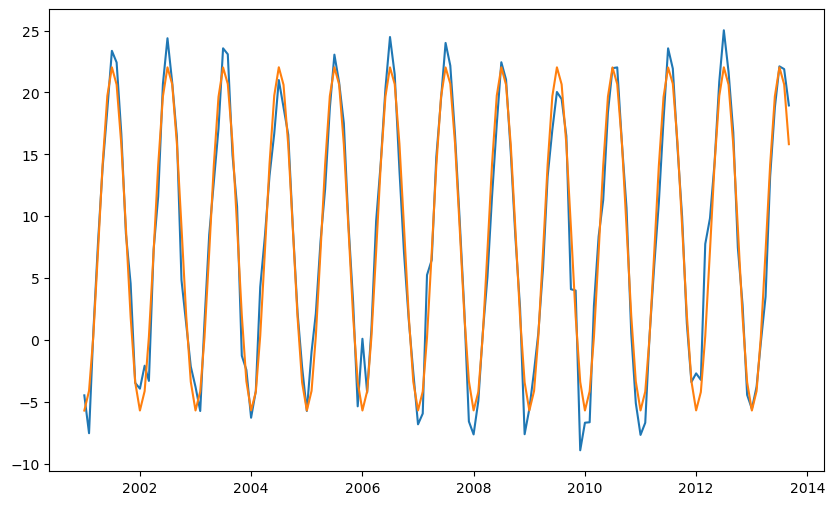

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np

#1.1
df = pd.read_csv("GlobalLandTemperaturesByState.csv")
df = df[["dt", "AverageTemperature", "State"]]
df["dt"] = pd.to_datetime(df["dt"])
df = df[df["dt"].dt.year > 2000]

specific_states = ["Wyoming", "Nebraska", "South Dakota"]
df = df[df["State"].isin(specific_states)]
df

#1.2
avg_temp_by_date = df.groupby("dt")["AverageTemperature"].mean().reset_index()
avg_temp_by_date.columns = ["Date", "AverageTemperature"]
print(avg_temp_by_date.head())

#1.3
plt.figure(figsize = (10,6))
plt.plot(avg_temp_by_date["Date"], avg_temp_by_date["AverageTemperature"])
plt.xlabel("Date")
plt.ylabel("Average Temperature (°C)")
plt.title("Average Temperature in Wyoming, Nebraska, & South Dakota after 2001")
plt.show()

#1.4
avg_temp_by_date["DateFloat"] = (avg_temp_by_date["Date"] - pd.Timestamp('2000-01-01')).dt.days / 365.25
print(avg_temp_by_date.head())

#1.5
def model(t, A, w, P, D):
    return A*np.cos(w*t + P) + D

initial_guess = [15, 2 * np.pi, 0, 10]

#1.6
popt, cov = curve_fit(model, avg_temp_by_date["DateFloat"], avg_temp_by_date["AverageTemperature"], p0=initial_guess)
A, w, P, D = popt

#1.7
plt.figure(figsize=(10, 6))
plt.plot(avg_temp_by_date["Date"], avg_temp_by_date["AverageTemperature"])
y_model = model(avg_temp_by_date["DateFloat"], A, w, P, D)  
plt.plot(avg_temp_by_date["Date"], y_model)

#1.8
parameter_errors = np.sqrt(np.diag(cov))

#1.9
print("Parameters with Errors: ")
parameter_labels = ["A", "w", "P", "D"]
for i in range(len(popt)):
    print(parameter_labels[i], ":", popt[i], "±", parameter_errors[i])
print("y =", round(popt[0],2) , "*cos(", round(popt[1],2) , "*t +", round(popt[2],2), ") +", round(popt[3],2))


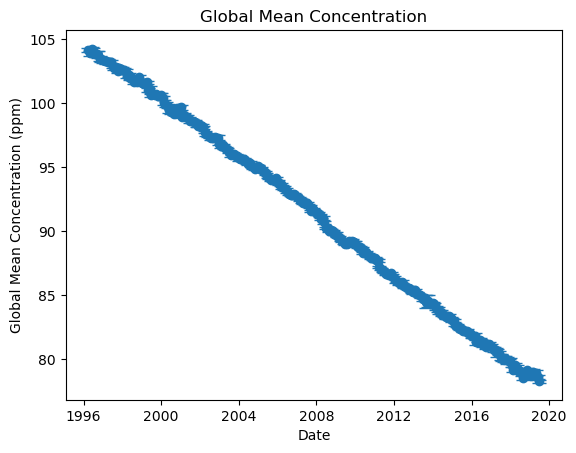

Slope: -0.003160616454942348 ± 3.506602935021391e-06
Intercept: 104.72877635977056 ± 0.016591318795805488
Reduced Chi-Squared: 4.444266235592556


"\nA linear model does seem appropriate because it fits the data well. \nAlthough it is under the blue data, it's clear that the orange line \nmatches the shape of the data well\n"

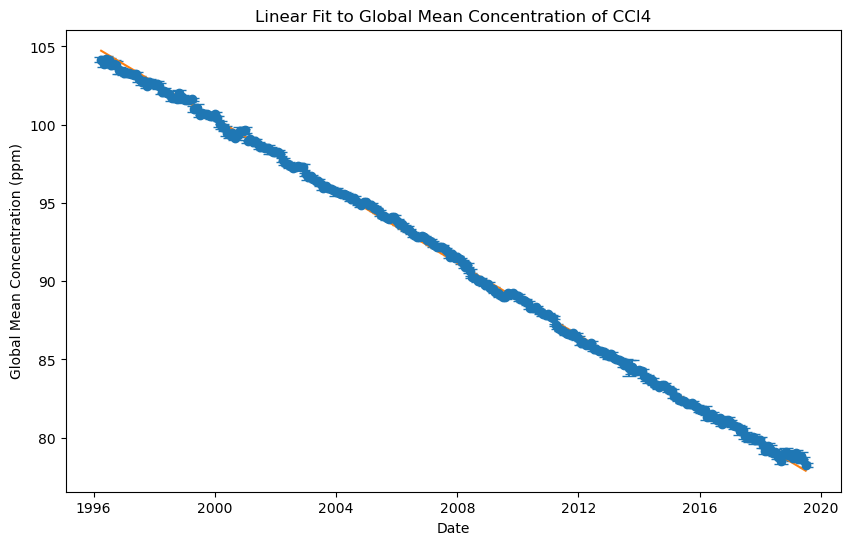

In [77]:
#1.10
from astropy.table import Table
table = Table.read("global_CCl4_MM.dat", format="ascii")
df = table.to_pandas()
df = df[["CCl4ottoyr", "CCl4ottomon", "CCl4ottoGLm", "CCl4ottoGLsd"]]
df.columns = ["Year", "Month", "GlobalMean", "GlobalSD"]
df["Date"] = pd.to_datetime(dict(year=df.Year, month=df.Month, day=1))
plt.errorbar(df["Date"], df["GlobalMean"], yerr=df["GlobalSD"], fmt='o', capsize=5)
plt.title("Global Mean Concentration")
plt.xlabel("Date")
plt.ylabel("Global Mean Concentration (ppm)")
plt.show()

def linear_model(x, m, b):
    return m*x + b

df_clean = df.dropna(subset=["GlobalMean", "GlobalSD"])
x_data = (df_clean["Date"] - df_clean["Date"].min()).dt.days
y_data = df_clean["GlobalMean"]
y_err = df_clean["GlobalSD"]

popt, cov = curve_fit(linear_model, x_data, y_data, sigma=y_err, absolute_sigma=True)

m, b = popt
m_err, b_err = np.sqrt(np.diag(cov))
print("Slope:", m, "±", m_err)
print("Intercept:", b, "±", b_err)

y_model = linear_model(x_data, m, b)

plt.figure(figsize=(10,6))
plt.errorbar(df["Date"], df["GlobalMean"], yerr=df["GlobalSD"], fmt='o', capsize=5)
plt.plot(df_clean["Date"], y_model)
plt.title("Linear Fit to Global Mean Concentration of CCl4")
plt.xlabel("Date")
plt.ylabel("Global Mean Concentration (ppm)")

residuals = y_data - y_model
chi_squared = np.sum((residuals / df["GlobalSD"])**2)
degrees_freedom = len(df_clean) - 2 
reduced_chi_squared = chi_squared / degrees_freedom
print("Reduced Chi-Squared: " + str(reduced_chi_squared))

'''
A linear model does seem appropriate because it fits the data well. 
Although it is under the blue data, it's clear that the orange line 
matches the shape of the data well
'''